<a href="https://colab.research.google.com/github/anjaperovic22/SeminarskiRad_NaprednaAnalizaPodataka/blob/main/Final_NAP_Projekat_AnjaPerovic20220174_ipynb_%E2%80%93_%D0%BA%D0%BE%D0%BF%D0%B8%D1%98%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projektni rad iz Napredne Analize Podataka

### Uvod

Svi smo svedoci razvoju digitalnih platformi i činjenici da se dostupnost online sadržaja povećava iz dana u dan. Ta pojava dovela je do ogromne količine tekstualnih podataka koje korisnici generišu, poput svojih stavova na raznorazne teme, recenzija proizvoda, komentara, mišljenja o različitim uslugama i objava na društvenim mrežama. Automatska analiza ovakvih podataka  ne predstavlja samo izazov već i važnu oblast istraživanja u okviru obrade prirodnog jezika (Natural Language Processing - NLP) i mašinskog učenja.



**Klasifikacija teksta** predstavlja jedan od najčešćih i uopšteno najznačajnijih zadataka ove oblasti, a njen cilj je upravo da se tekstualni dokumenti automatski razvrstaju u unapred definisane kategorije.


**Tema** ovog rada jeste kreiranje i poređenje više modela za klasifikaciju teksta na osnovu sadržaja korisničkih recenzija.
**Predmet** rada obuhvata klasifikaciju tekstualnih recenzija Disneyland tematskih parkova prema lokaciji parka na koji se recenzija odnosi.
**Svrha** rada je ispitivanje uticaja različitih načina reprezentacije teksta i različitih algoritama mašinskog učenja na uspešnost klasifikacije, kao i identifikacija pristupa koji daje najbolje rezultate u ovom konkretnom problemu.

Skup podataka korišćen u daljem radu je preuzet sa online platforme [Kaggle.com](https://www.kaggle.com/datasets/arushchillar/disneyland-reviews) koji sadrži recenzije korisnika o Disneyland parkovima širom sveta. Za kompanije poput Disneylanda, sposobnost automatskog prepoznavanja obrazaca među hiljadama recenzija omogućava brže reakcije na korisničko nezadovoljstvo i preciznije prilagođavanje usluga u zavisnosti od specifičnosti tržišta.

### Učitavanje neophodnih biblioteka

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sb
import spacy

from collections import defaultdict

from spacy import displacy

from numpy.linalg import norm

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.dummy import DummyClassifier
from sklearn import set_config
set_config(display='diagram')
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.linear_model import LogisticRegression

In [ ]:
RAND_STATE = 42

### Učitavanje i pregled skupa podataka

In [ ]:
from google.colab import files
data_file = files.upload()

Saving DisneylandReviews.csv to DisneylandReviews.csv


In [ ]:
disneyland = list(data_file.keys())[0]
data = pd.read_csv(disneyland, encoding='latin-1') #dodat encoding zbog UnicodeError-a

In [ ]:
data.sample(10)

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
9012,124158445,5,Oct-11,United States,Smaller park compared to the USA mainland park...,Disneyland_HongKong
33067,429122732,5,Oct-16,United Kingdom,"Spent one day in Disneyland Paris, squeezed in...",Disneyland_Paris
42080,100241034,1,Mar-11,United Kingdom,do not waste your money if you are looking for...,Disneyland_Paris
31599,512182229,3,Aug-17,United Kingdom,This is our 5th time to Disney land Paris and ...,Disneyland_Paris
22909,187759984,5,Dec-13,Australia,It simply magical. Everything about it is amaz...,Disneyland_California
27218,126168453,4,missing,United States,always fun for young and old and always expens...,Disneyland_California
12496,501258807,5,Apr-17,United States,I hadn't been to Disneyland in probably 20 yea...,Disneyland_California
27087,126744741,5,Mar-12,United States,"I love everything Disneyland! The food, the at...",Disneyland_California
445,636961092,5,Dec-18,India,Our visit to Disneyland was planned solely for...,Disneyland_HongKong
15161,387553054,5,Sep-15,U.S. Virgin Islands,this is a great park and friendly vibes all ar...,Disneyland_California


Svaka instanca sadrži identifikatore (koji nam neće biti relevantni u našoj analizi), ocenu, vremensku odrednicu potom nama najznačajniji deo - nestruktuirani tekst recenzije i ciljnu promenjivu.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42117 entries, 0 to 42116
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Review_ID          42117 non-null  int64 
 1   Rating             42117 non-null  int64 
 2   Year_Month         42117 non-null  object
 3   Reviewer_Location  42117 non-null  object
 4   Review_Text        42117 non-null  object
 5   Branch             42117 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


**Cilj** ovog rada je automatska klasifikacija lokacije Disneyland parka na osnovu **tekstualnog sadržaja korisničkih recenzija**. Motivacija za ovakav zadatak proističe iz činjenice da se korisnička iskustva, očekivanja i način izražavanja posetilaca mogu značajno razlikovati u zavisnosti od geografske lokacije i kulture. Posetioci različitih parkova mogu obraćati pažnju na različite aspekte iskustva (npr. uslugu, gužvu, sadržaj, organizaciju), kao i koristiti različit stil i vokabular prilikom opisivanja svojih utisaka.

In [ ]:
data.Branch.value_counts()

,count
Branch,
Disneyland_California,19406
Disneyland_Paris,13091
Disneyland_HongKong,9620


### Smanjenje skupa podataka

Najpre ćemo definisati funkciju branch_to_cls koja će nam vratiti naziv mesta u kome se park nalazi radi lakšeg pregleda klasi u daljoj analizi podataka.

In [ ]:
def branch_to_cls(column):
  if column == 'Disneyland_California':
    return 'California'
  elif column == 'Disneyland_Paris':
    return 'Paris'
  else:
    return 'Hong Kong'

In [ ]:
data['Class'] = data.Branch.apply(branch_to_cls)

S obzirom na to da originalni skup podataka sadrži veliki broj instanci, u ovom koraku je izvršeno smanjenje (*subsampling*) skupa podataka kako bi se ubrzalo treniranje modela i smanjila računarska složenost daljih analiza. Smanjenje skupa podataka je sprovedeno na stratifikovan način, tako da se zadrže približno iste proporcije klasa (lokacija) kao u originalnom skupu. Na ovaj način obezbeđeno je da redukovani skup podataka ostane reprezentativan u odnosu na početnu raspodelu klasa, dok se istovremeno omogućava efikasnije eksperimentisanje sa različitim modelima i hiper-parametrima.

In [ ]:
TARGET_SIZE = 6000

class_proportions = data['Branch'].value_counts(normalize=True)

data_reduced = (
    data
    .groupby('Branch', group_keys=False)
    .apply(lambda x: x.sample(
        n=int(TARGET_SIZE * class_proportions[x.name]),
        random_state=RAND_STATE
    ))
)


/tmp/ipython-input-1693023173.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(


### Provera balansiranosti skupa podataka

Ispitivanje balansiranosti skupa podataka je ključno jer značajno utiče na ponašanje i pouzdanost modela klasifikacije, izbor evaluacionih metrika i potrebu za primenom tehnika za korekciju neuravnoteženosti klasa.

In [ ]:
data['Class'].value_counts(normalize=True)

,proportion
Class,
California,0.460764
Paris,0.310825
Hong Kong,0.228411


In [ ]:
data_reduced['Class'].value_counts(normalize=True)

,proportion
Class,
California,0.460820
Paris,0.310770
Hong Kong,0.228409


Analizom raspodele ciljne promenljive utvrđeno je da skup podataka nije izbalansiran. Klasa **California** čini približno 46.1% svih instanci, dok su klase **Paris** i **Hong Kong** zastupljene sa oko 31.1% i 22.8%, respektivno. Možemo da zaključimo da najzastupljenija klasa ima skoro dvostruko veći broj primera u odnosu na najmanje zastupljenu klasu, što ukazuje na postojanje izražene neravnoteže u podacima.

Na osnovu ovih rezultata može se zaključiti da redukovani skup podataka verodostojno reprezentuje originalni skup, te da se razlike u raspodeli klasa mogu smatrati statistički zanemarljivim. Samim tim, redukovani skup podataka je adekvatan za dalju analizu i treniranje klasifikacionih modela, bez rizika od narušavanja distribucije ciljne promenljive.

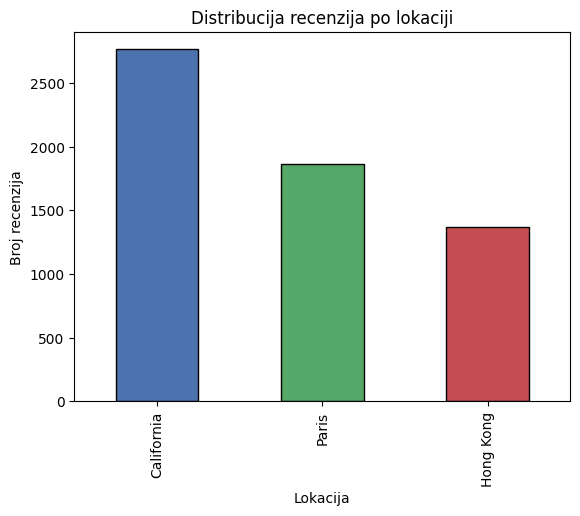

In [ ]:
colors = ['#4C72B0', '#55A868', '#C44E52']

data_reduced['Class'].value_counts().plot(
    kind='bar',
    color=colors,
    edgecolor='black'
)

plt.title('Distribucija recenzija po lokaciji')
plt.xlabel('Lokacija')
plt.ylabel('Broj recenzija')
plt.show()

Sa grafikona nije teško zaključiti da je broj recenzija po lokacijama neujednačen.

Najveći broj recenzija dolazi iz Disneyland California, zatim iz Disneyland Paris, dok je najmanji broj recenzija vezan za Disneyland Hong Kong. Ovakva raspodela ukazuje na postojanje klasne neuravnoteženosti u početnom skupu podataka, što može negativno uticati na performanse klasifikacionih modela, posebno na tačnost predviđanja za manje zastupljene klase.

/tmp/ipython-input-37311585.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.boxplot(


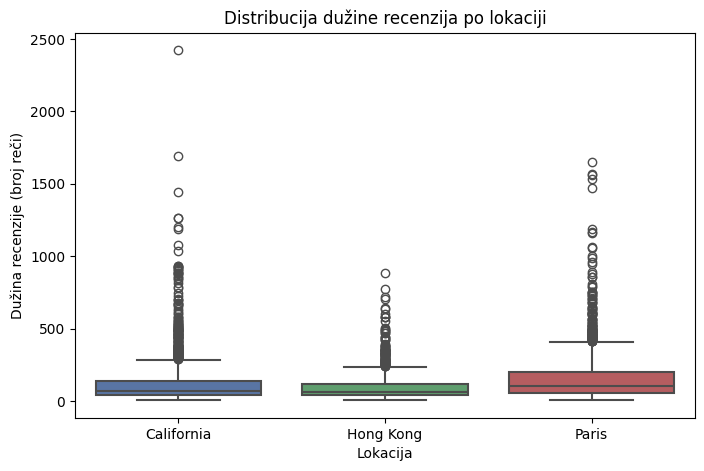

In [ ]:
colors = ['#4C72B0', '#55A868', '#C44E52']

data_reduced['Review_Length'] = data_reduced['Review_Text'].str.split().apply(len)

plt.figure(figsize=(8, 5))

sb.boxplot(
    data=data_reduced,
    x='Class',
    y='Review_Length',
    palette=colors,
    showfliers=True,     #outlieri ostaju (bitni su ovde)
    linewidth=1.5
)

plt.title('Distribucija dužine recenzija po lokaciji')
plt.xlabel('Lokacija')
plt.ylabel('Dužina recenzije (broj reči)')
plt.show()

Boxplot prikazuje raspodelu dužine recenzija (broj reči) po lokacijama Disneyland parkova. Uočava se da recenzije za **Paris** imaju najveću medijanu i najširi raspon, što ukazuje da su u proseku duže i sadržajnije u poređenju sa ostalim lokacijama. Recenzije za **Hong Kong** su u proseku kraće i imaju manju varijabilnost, dok **California** pokazuje najveći broj ekstremnih vrednosti (outliera), odnosno veoma dugih recenzija.

Prisutnost velikog broja outliera i razlike u dužini recenzija među lokacijama ukazuju da dužina teksta može predstavljati informativnu numeričku karakteristiku za klasifikaciju. Iako boxplot ukazuje na postojanje ekstremnih vrednosti u dužini recenzija, u daljem radu nije vršena njihova normalizacija. Odlučila sam da se ovi podaci zadrže u izvornom obliku kako bi se očuvala njihova jasna interpretacija, dok je primarni fokus istraživanja usmeren na analizu samog tekstualnog sadržaja i ocena korisnika.

In [ ]:
data_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5998 entries, 16434 to 36881
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Review_ID          5998 non-null   int64 
 1   Rating             5998 non-null   int64 
 2   Year_Month         5998 non-null   object
 3   Reviewer_Location  5998 non-null   object
 4   Review_Text        5998 non-null   object
 5   Branch             5998 non-null   object
 6   Class              5998 non-null   object
 7   Review_Length      5998 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 421.7+ KB


### Odabir promenjivih za analizu

Automatizovana identifikacija lokacije na osnovu teksta recenzije može imati praktičnu primenu u sistemima za analizu korisničkog iskustva, omogućavajući segmentaciju povratnih informacija po regionima čak i u slučajevima kada podaci o lokaciji nisu dostupni ili su nepotpuni. Takođe, ovakav pristup može pomoći u identifikaciji specifičnih obrazaca u jeziku i temama koje su karakteristične za pojedine lokacije.

Pored tekstualnih podataka, u radu se razmatra i uticaj dodatnih numeričkih karakteristika, kao što su dužina recenzije i ocena, koje mogu dodatno doprineti tačnosti klasifikacije.



In [ ]:
ds = data_reduced[['Rating','Review_Length','Review_Text','Class']]
ds.sample(10)

,Rating,Review_Length,Review_Text,Class
36766,4,28,"Beautiful, fairy tale like place... Depends du...",Paris
40822,5,134,"There is a toy town, beautiful, surprising, va...",Paris
26446,4,61,First thing in the morning is a great experien...,California
29677,5,70,You will enjoy this day for the rest of your l...,Paris
25758,5,105,What can I say? It's Disneyland! You really fe...,California
9441,5,118,We visited recently with our 3 year old daught...,Hong Kong
41428,4,96,I suggested you when visiting disney park try ...,Paris
33876,5,263,We booked Express Shuttle with entrance ticket...,Paris
2110,3,145,I grew up in the U.S. but now live in Hong Kon...,Hong Kong
32095,2,96,It has a good atmosphere. My kids enjoyed the ...,Paris


### Pretprocesiranje recenzija

U sledećem delu koda, definisaćemo funkcije za pretprocesiranje teksta korišćenjem spaCy biblioteke.

**spaCy** je biblioteka otvorenog koda za obradu prirodnog jezika u programskom jeziku Python. Posebno je dizajnirana za izgradnju aplikacija koje na efikasan način obrađuju velike količine tekstualnih podataka. Prilikom korišćenja neophodno je da učitamo osnovni engleski jezički model ove biblioteke.

In [ ]:
nlp_pipe = spacy.load('en_core_web_sm')

Jedna od stvari koje sam primetila tokom predobrade tekstualnih podataka odnosi se na tretman *stop reči*. Iako se stop reči uobičajeno uklanjaju kako bi se smanjio šum u podacima, prilikom istraživanja je uočeno da njihovo potpuno uklanjanje nije uvek optimalno rešenje. Posebna pažnja posvećena je negacijama (poput *„no“, „not“, „never“*), koje mogu značajno promeniti značenje iskaza i uticati na interpretaciju teksta.

Zbog toga je doneta odluka da se negacije zadrže u tekstu, dok su ostale stop reči uklonjene. Ovakav pristup omogućava očuvanje semantički relevantnih informacija, uz istovremeno smanjenje nepotrebnog šuma, što može doprineti boljim performansama klasifikacionih modela.

In [ ]:
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS

negations = {'no', 'not', 'never'}

print(f'Ukupan broj stop reči: {len(spacy_stopwords)}\n')

print("Da li su negacije među stop rečima:")
for neg in negations:
    print(f"{neg}: {neg in spacy_stopwords}")

Ukupan broj stop reči: 326

Da li su negacije među stop rečima:
no: True
not: True
never: True


In [ ]:
def spacy_preprocessing(
    doc, #ulazni tekst (recenzija)
    remove_stopwords=True, #da li se uklanjaju stop reci
    keep_negations=True, #da li se ostavljaju negacije
    min_token_length=3 #minimalna duzina tokena
):

    tokens = nlp_pipe(doc)
    cleaned_tokens = []

    for token in tokens:

        if token.is_punct or token.is_space or token.like_num or token.like_url:
            continue

        if remove_stopwords and token.is_stop:
            if keep_negations and token.lemma_.lower() in ['not', 'no', 'never']:
                pass  #zadrzavamo negacije
            else:
                continue

        lemma = token.lemma_.lower()

        if len(lemma) < min_token_length:
            continue

        cleaned_tokens.append(lemma)

    return cleaned_tokens

Na primeru jedne nasumično izabrane recenzije prikazan je efekat predobrade teksta. Može se uočiti da se uklanjanjem stop reči, interpunkcije i nepotrebnih tokena značajno smanjuje dužina teksta, dok se zadržavaju semantički relevantne reči.

In [ ]:
sample_review = ds.sample(random_state=RAND_STATE)['Review_Text'].iloc[0]

cleaned_tokens = spacy_preprocessing(sample_review)

print("ORIGINALNA RECENZIJA:\n")
print(sample_review+"\n")
print("RECENZIJA NAKON PREPROCESIRANJA:\n")
print(" ".join(cleaned_tokens))

print(f"\nBroj tokena pre obrade: {len(sample_review.split())}")
print(f"Broj tokena posle obrade: {len(cleaned_tokens)}")

ORIGINALNA RECENZIJA:

Disneyland Park have sectioned off viewing areas for the privileged. These sections are not open up to guests even if they are not filled. Way to make your guests feel welcome Mickey.In addition to selfie sticks, many things are banned. You are forced to take it back to your car or donate it to goodwill. If you have a kid who wants to have fun with a non Disney approved bubble blower, security may screams at your kid and force you to throw the toy away or take it to your car. It is very sad to see. The little boy did not understand why he was screamed at.Follow all rules and be prepared to wait and wait and wait for your happiness and hold on to your hunger, you poor, unfortunate souls. No all day dinning for you. ;)

RECENZIJA NAKON PREPROCESIRANJA:

disneyland park section view area privileged section not open guest not fill way guest feel welcome mickey addition selfie stick thing ban force car donate goodwill kid want fun non disney approve bubble blower secu

### Priprema podataka za trening

U ovom koraku izvršena je priprema podataka za treniranje klasifikacionih modela. Kao ulazne promenljive (**X**) korišćeni su tekst recenzije (Review_Text), dužina recenzije izražena brojem reči (Review_Length) i numerička ocena korisnika (Rating). Ciljna promenljiva (**y**) predstavlja klasu (Class), odnosno geografsku lokaciju Disneyland parka na koji se recenzija odnosi.

S obzirom na to da većina algoritama mašinskog učenja zahteva numerički format ciljne promenljive, korišćenjem funkcije factorize() iz Pandas biblioteke kategorijske vrednosti transformisane su u numeričke oznake. Dobijeno mapiranje sačuvano je radi kasnije interpretacije rezultata.

Na kraju, skup podataka podeljen je na trening i test skup u odnosu 80:20, uz primenu stratifikacije po ciljnoj promenljivoj kako bi se zadržale iste proporcije klasa u oba skupa. Ovakva podela omogućava fer i pouzdano poređenje performansi različitih klasifikacionih modela.

In [ ]:
X = ds[['Review_Text', 'Review_Length', 'Rating']]
y = ds['Class']

y_enc, y_levels = pd.factorize(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc,
    test_size=0.2,
    random_state=RAND_STATE,
    stratify=y_enc
)

# Model 1: **BoW + Multinomial Naive Bayes**

In [ ]:
#Bag of Words vektorizator
bow_vectorizer = CountVectorizer(
    tokenizer=spacy_preprocessing, #ranije def. spaCy funkcija
    ngram_range=(1, 2), #unigrami i bigrami
    min_df=0.01 #ignorisanje retkih reci
)

#Kombinovanje tekstualnih i numerickih atributa
column_transformer = ColumnTransformer(
    transformers=[
        ('bow', bow_vectorizer, 'Review_Text')
    ],
    remainder='passthrough'
)

#Definisanje pipeline-a
pipe_bow_nb = Pipeline([
    ('vectorizer', column_transformer),
    ('classifier', MultinomialNB())
])

#Treniranje modela
pipe_bow_nb.fit(X_train, y_train)

#Predikcija na test skupu
predictions_bow = pipe_bow_nb.predict(X_test)

#Evaluacija
print("\n Classification report (BoW + MultinomialNB) \n")
print(metrics.classification_report(y_test, predictions_bow, target_names=y_levels))

print("Balanced accuracy:",
      metrics.balanced_accuracy_score(y_test, predictions_bow))

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(



 Classification report (BoW + MultinomialNB) 

              precision    recall  f1-score   support

  California       0.85      0.82      0.84       553
   Hong Kong       0.68      0.81      0.74       274
       Paris       0.81      0.73      0.77       373

    accuracy                           0.79      1200
   macro avg       0.78      0.79      0.78      1200
weighted avg       0.80      0.79      0.79      1200

Balanced accuracy: 0.7885933067889676


Kao bazni klasifikacioni model korišćen je Bag of Words pristup u kombinaciji sa Multinomial Naive Bayes algoritmom. Model je postigao ukupnu tačnost od približno 79%, dok je balansirana tačnost iznosila oko 78.9%, što ukazuje na stabilne performanse i u uslovima neuravnotežene raspodele klasa.

Analiza performansi po klasama pokazuje da model najbolje prepoznaje recenzije koje se odnose na klasu **California**, što je očekivano s obzirom na najveći broj primera iz te klase. Klasa **Hong Kong** ima visok recall, ali nešto nižu preciznost, dok klasa **Paris** pokazuje uravnotežene, ali nešto slabije rezultate u pogledu recall metrike.

Dobijeni rezultati ukazuju da jednostavan Bag of Words model predstavlja dobru početnu tačku za klasifikaciju teksta, ali i ostavlja prostor za unapređenje primenom kompleksnijih metoda za reprezentaciju teksta i jačih klasifikacionih algoritama.

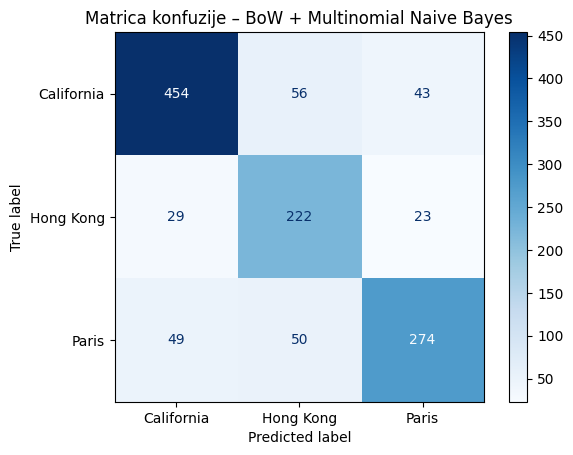

In [ ]:
ConfusionMatrixDisplay.from_estimator(
    pipe_bow_nb,
    X_test,
    y_test,
    display_labels=y_levels,
    cmap='Blues'
)

plt.title("Matrica konfuzije – BoW + Multinomial Naive Bayes")
plt.show()

Prema datoj matrici konfuzije, možemo da iznesemo zaključak da je što se tiče

*   klase **California**: prisutno 454 tačno predviđenih instanci, dok je 56 netačno prepoznato kao Hong Kong i 43 kao Paris
*   klase **Hong Kong**: prisutno 222 tačno predviđenih instanci, dok je 29 netačno prepoznato kao California i 23 kao Paris
*   klase **Paris**: prisutno 274 tačno predviđenih instanci dok je 49 netačno prepoznato kao California i 50 kao Hong Kong

U slučaju klase **Paris**, primećuje se proporciono veći broj pogrešnih klasifikacija ka preostalim klasama. Samo neki od mogućih razloga su:
1. velika raznolikost posetilaca (različite kulture i stilovi izražavanja)
2. recenzije često imaju opštiji turistički ton koji je fokusiran na gužvu, cenu, atmosferu i organizaciju.
Ove stavke se ne razlikuju strogo po lokaciji već su zajedničke svim klasama.

Nasuprot tome, klasa **California** je najbolje klasifikovana. Mogući razlozi tome su što je u pitanju originalni park i često je pominjan kao *classic*, *original*, ...

Dobijeni rezultati mogu se delimično objasniti ograničenjima BoW modela, koji ne uzima u obzir kontekst i semantičke odnose među rečima. S obzirom da se veliki broj recenzija nezavisno od lokacije oslanja na sličan vokabular za opis korisničkog iskustva (npr. *crowded, expensive, long lines, staff, kids, fun…*) model ima poteškoće u razdvajanju klasa.







###Unapređenje Modela 1: **Poboljšanje klasifikatora podešavanjem hiperparametara**

U cilju unapređenja performansi baznog modela, izvršeno je podešavanje hiperparametara korišćenjem GridSearchCV metode. Testirane su različite vrednosti hiperparametra min_df, koji kontroliše minimalnu učestalost pojavljivanja termina u dokumentima. Kros-validacijom na trening skupu odabrana je optimalna vrednost, nakon čega je model ponovo treniran i evaluiran na test skupu.

In [ ]:
param_grid = {
    'vectorizer__bow__min_df': [0.005, 0.01, 0.025, 0.05]
}

grid_search = GridSearchCV(
    estimator=pipe_bow_nb,
    param_grid=param_grid,
    scoring='balanced_accuracy',  #zbog neuravnotezenih klasa
    verbose=2
)

grid_search.fit(X_train, y_train)

print('Najbolji hiperparametri:', grid_search.best_params_)
print('Najbolji rezultat (CV score):', grid_search.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END ......................vectorizer__bow__min_df=0.005; total time= 2.7min


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END ......................vectorizer__bow__min_df=0.005; total time= 3.5min


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END ......................vectorizer__bow__min_df=0.005; total time= 2.4min


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END ......................vectorizer__bow__min_df=0.005; total time= 2.4min


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END ......................vectorizer__bow__min_df=0.005; total time= 2.4min


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END .......................vectorizer__bow__min_df=0.01; total time= 2.3min


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END .......................vectorizer__bow__min_df=0.01; total time= 2.3min


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END .......................vectorizer__bow__min_df=0.01; total time= 2.3min


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END .......................vectorizer__bow__min_df=0.01; total time= 2.3min


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END .......................vectorizer__bow__min_df=0.01; total time= 2.3min


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END ......................vectorizer__bow__min_df=0.025; total time= 2.4min


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END ......................vectorizer__bow__min_df=0.025; total time= 2.3min


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END ......................vectorizer__bow__min_df=0.025; total time= 2.3min


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END ......................vectorizer__bow__min_df=0.025; total time= 2.3min


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END ......................vectorizer__bow__min_df=0.025; total time= 2.3min


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END .......................vectorizer__bow__min_df=0.05; total time= 2.3min


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END .......................vectorizer__bow__min_df=0.05; total time= 2.3min


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END .......................vectorizer__bow__min_df=0.05; total time= 2.3min


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END .......................vectorizer__bow__min_df=0.05; total time= 2.3min


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[CV] END .......................vectorizer__bow__min_df=0.05; total time= 2.3min


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Najbolji hiperparametri: {'vectorizer__bow__min_df': 0.005}
Najbolji rezultat (CV score): 0.7977037251352215


Šta se zapravo dešava u našoj analizi nakon ove izmene? Iako vrednost 0.005 deluje mala, ona je značajna za nas. Imamo približno 6000 instanci, dakle: **0.005 * 6000 = 30**

Reč mora da se pojavi u najmanje ~30 recenzija da bi ušla u model.

Dakle izbačene su ekstremno retke reči (najverovatnije greške u kucanju i slično). Zadržane su reči koje imaju neku stabilnost i pojavljuju se u više  recenzija korisnika.



In [ ]:
#Izdvajamo najbolju vrednost min_df
best_min_df = grid_search.best_params_['vectorizer__bow__min_df']

#Postavljamo pipeline na najbolju vrednost hiperparametra
pipe_bow_nb.set_params(vectorizer__bow__min_df=best_min_df)

#Ponovo treniramo model na celom trening skupu
pipe_bow_nb.fit(X_train, y_train)

#Pravimo predikcije nad test skupom
predictions_tuned = pipe_bow_nb.predict(X_test)

#Evaluacija
print("\nClassification report (BoW + NB, tuned) \n")
print(metrics.classification_report(y_test, predictions_tuned, target_names=y_levels))

print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test, predictions_tuned))

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(



Classification report (BoW + NB, tuned) 

              precision    recall  f1-score   support

  California       0.87      0.84      0.86       553
   Hong Kong       0.71      0.84      0.77       274
       Paris       0.84      0.76      0.80       373

    accuracy                           0.82      1200
   macro avg       0.81      0.82      0.81      1200
weighted avg       0.82      0.82      0.82      1200

Balanced accuracy: 0.8159919182376817


U cilju unapređenja performansi baznog Bag of Words modela, izvršeno je podešavanje hiperparametra min_df korišćenjem GridSearchCV metode. Testiranjem više vrednosti ovog parametra utvrđeno je da niža vrednost (min_df = 0.005) omogućava zadržavanje informativnih termina, uz istovremeno smanjenje šuma.

Nakon podešavanja hiperparametara, model je ostvario poboljšanje u svim relevantnim metrikama, pri čemu je balansirana tačnost porasla sa približno 79% na oko 81.6%. Posebno je uočeno poboljšanje u performansama za manje zastupljene klase, što ukazuje na pozitivno dejstvo uvođenja hiperparametara u uslovima neuravnoteženog skupa podataka.

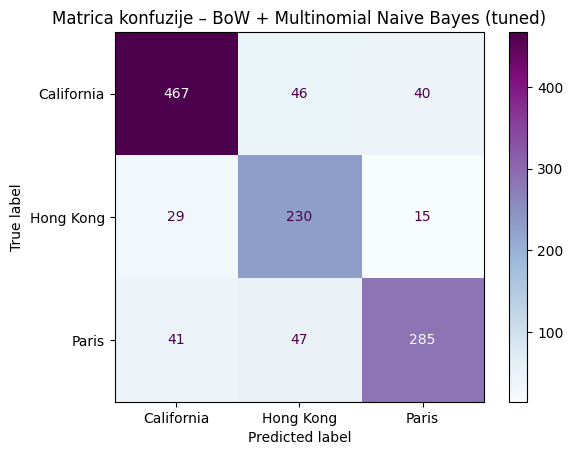

In [ ]:
ConfusionMatrixDisplay.from_predictions(
    y_test,
    predictions_tuned,
    display_labels=y_levels,
    cmap='BuPu'
)

plt.title("Matrica konfuzije – BoW + Multinomial Naive Bayes (tuned)")
plt.show()

Prema datoj matrici konfuzije, možemo da iznesemo zaključak da je što se tiče


*   klase **California**: prisutno je 467 tačno predviđenih instanci, dok je 46
netačno prepoznato kao Hong Kong i 40 kao Paris
*   klase **Hong Kong**: prisutno je 230 tačno predviđenih instanci, dok je 29 netačno prepoznato kao California i 15 kao Paris
*   klase **Paris**: prisutno je 285 tačno predviđenih instanci dok je 41 netačno prepoznato kao California i 47 kao Hong Kong


Ukoliko bismo sada uporedili vrednosti u BoW+MNB matrici konfuzije sa vrednostima BoW+MNB(tuned) možemo da zaključimo da je povećan broj tačno klasifikovanih instanci.

Klasa **California** i u unapređenom modelu ostaje najbolje klasifikovana. U odnosu na prvobitni model, nakon podešqavanja najboljeg hiperparametara smanjuje se broj pogrešno klasifikovanih instanci klase **Hong Kong**. Najznačajnije poboljšanje primećuje se kod klase **Paris**, gde je broj tačno klasifikovanih instanci povećan, a pogrešnih smanjen.

Ovo nam ukazuje na činjenicu da je za model bolje da iskoristi učestalije termine koje nose specifične informacije o nekoj lokaciji pri čemu se eliminišu previše retke reči koje doprinose razdvajanju klasa.



# Model 2: **TF-IDF + Multinomial Naive Bayes**

In [ ]:
tfidf_vectorizer = TfidfVectorizer(
    tokenizer=spacy_preprocessing,
    ngram_range=(1, 2),
    min_df=0.01,
    norm='l2',#standardna L2 normalizacija
    use_idf=True,
    smooth_idf=True
)


column_transformer_tfidf = ColumnTransformer(
    transformers=[
        ('tfidf', tfidf_vectorizer, 'Review_Text')
    ],
    remainder='passthrough'
)

pipe_tfidf_nb = Pipeline([
    ('vectorizer', column_transformer_tfidf),
    ('classifier', MultinomialNB())
])

pipe_tfidf_nb.fit(X_train, y_train)
predictions_tfidf_mnb = pipe_tfidf_nb.predict(X_test)

print("\nClassification report (TF-IDF + Multinomial Naive Bayes) \n")
print(metrics.classification_report(y_test, predictions_tfidf_mnb, target_names=y_levels))

bacc_tfidf = metrics.balanced_accuracy_score(y_test, predictions_tfidf_mnb)
print(f"Balanced accuracy: {bacc_tfidf:.4f}")

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(



Classification report (TF-IDF + Multinomial Naive Bayes) 

              precision    recall  f1-score   support

  California       0.75      0.79      0.77       553
   Hong Kong       0.62      0.69      0.65       274
       Paris       0.66      0.55      0.60       373

    accuracy                           0.69      1200
   macro avg       0.68      0.68      0.67      1200
weighted avg       0.69      0.69      0.69      1200

Balanced accuracy: 0.6780


Rezultati klasifikacije pokazuju da TF-IDF u kombinaciji sa Multinomial Naive Bayes klasifikatorom ostvaruje umerene performanse, sa ukupnom tačnošću od oko 69% i balansiranom tačnošću od približno 67.8%.

Najbolje performanse ostvarene su za klasu **California**, što je očekivano s obzirom na njenu veću zastupljenost u skupu podataka. Nasuprot tome, klase **Hong Kong** i **Paris** imaju niže vrednosti preciznosti i odziva, što ukazuje na otežanu separaciju ovih klasa na osnovu TF-IDF karakteristika u kombinaciji sa Naive Bayes pretpostavkom nezavisnosti osobina.

Postavlja se pitanje zašto je korišćenje TD-IDF došlo do značajnog opadanja balansirane tačnosti? Šta u vezi ovog modela dovodi do toliko lošijeg rezultata u našoj analizi?

Odgovor je zapravo prost i direktno povezan sa time zašto je prethodni model postigao bolje rezultate. TD-IDF potiskuje česte reči, naglašavajući retke. U kontekstu recenzija Disneyland parkova, razlike među lokacijama najočiglednije su kroz učestale, ponavljajuće termine a ne kroz retke reči. Npr.

*   **California**: *“original”, “classic”, “first”, “US”*
*   **Paris**: *“crowded”, “expensive”, “European”, “Paris”*
*   **Hong Kong**: *“family”, “small”, “clean”, “Chinese”*

S obzirom da TD-IDF umanjuje značaj ovakvih termina i povećava težinu reči koje se retko javljaju u tekstu (često nisu značajne za određivanje lokacije) model gubi informacije ključne za određivanje geografske lokacije.


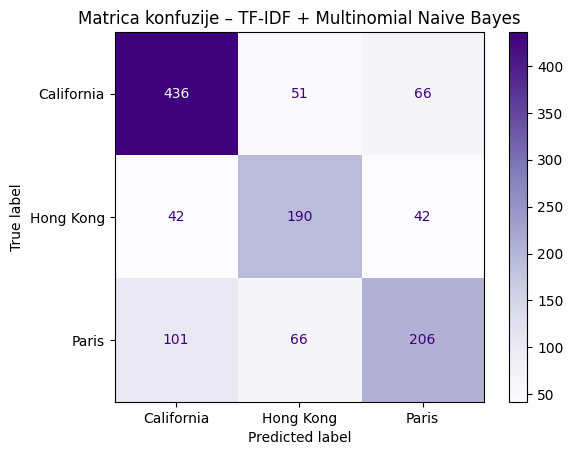

In [ ]:
ConfusionMatrixDisplay.from_estimator(
    pipe_tfidf_nb,
    X_test,
    y_test,
    display_labels=y_levels,
    cmap='Purples'
)

plt.title("Matrica konfuzije – TF-IDF + Multinomial Naive Bayes")
plt.show()

Prema datoj matrici konfuzije, možemo da iznesemo zaključak da je što se tiče

*   klase **California**: prisutno 436 tačno predviđenih instanci, dok je 51
netačno prepoznato kao Hong Kong i 66 kao Paris
*   klase **Hong Kong**: prisutno 190 tačno predviđenih instanci, dok je po 42 netačno prepoznato kao California i Paris
*   klase **Paris**: prisutno 206 tačno predviđenih instanci dok je 101 netačno prepoznato kao California i 66 kao Hong Kong

Ova matrica pokazuje da model najuspešnije klasifikuje recenzije koje pripadaju klasi **California**, dok su greške izraženije kod klasa **Hong Kong** i **Paris**. Posebno je uočljivo da se značajan broj recenzija iz klase **Paris** pogrešno klasifikuje kao **California**, što može ukazivati na slične obrasce u jeziku ili temama koje se javljaju u recenzijama ovih lokacija.

Takođe, primećuje se preklapanje između klasa **Hong Kong** i **Paris**, što dodatno otežava razdvajanje ovih klasa korišćenjem Multinomial Naive Bayes klasifikatora u kombinaciji sa TF-IDF reprezentacijom teksta.

# Model 3: **TF-IDF + Linear SVM (LinearSVC)**

Nakon evaluacije Naive Bayes modela, primenjen je Support Vector Machine sa linearnim kernelom, koji se često pokazuje kao jedan od najefikasnijih algoritama za zadatke klasifikacije teksta.

In [ ]:
tfidf_vectorizer = TfidfVectorizer(
    tokenizer=spacy_preprocessing,
    ngram_range=(1, 2),
    min_df=0.01,
    norm='l2',
    use_idf=True,
    smooth_idf=True
)

column_transformer_tfidf = ColumnTransformer(
    transformers=[
        ('tfidf', tfidf_vectorizer, 'Review_Text')
    ],
    remainder='passthrough'
)

pipe_tfidf_svm = Pipeline([
    ('vectorizer', column_transformer_tfidf),
    ('classifier', LinearSVC(random_state=RAND_STATE))
])

pipe_tfidf_svm.fit(X_train, y_train)
predictions_tfidf_svm = pipe_tfidf_svm.predict(X_test)

print("\n Classification report (TF-IDF + Linear SVM) \n")
print(metrics.classification_report(y_test, predictions_tfidf_svm, target_names=y_levels))

bacc_svm = metrics.balanced_accuracy_score(y_test, predictions_tfidf_svm)
print(f"Balanced accuracy: {bacc_svm:.4f}")

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(



 Classification report (TF-IDF + Linear SVM) 

              precision    recall  f1-score   support

  California       0.80      0.83      0.82       553
   Hong Kong       0.78      0.70      0.74       274
       Paris       0.75      0.76      0.76       373

    accuracy                           0.78      1200
   macro avg       0.78      0.77      0.77      1200
weighted avg       0.78      0.78      0.78      1200

Balanced accuracy: 0.7674


Rezultati klasifikacije pokazuju da TF-IDF u kombinaciji sa Linear SVM klasifikatorom ostvaruje bolje i uravnoteženije performanse u poređenju sa TF-IDF + Multinomial Naive Bayes modelom. Ukupna tačnost modela iznosi oko 78%, dok balansirana tačnost dostiže približno 76.7%, što ukazuje na solidnu sposobnost modela da ravnomerno tretira sve klase.

U poređenju sa prethodnim modelom, primećeno je poboljšanje preciznosti i F1-mere za klase **Hong Kong** i **Paris**.

TD-IDF + Linear SVM ostvario je bolje rezultate u odnosu na TD-IDF + Multinomial Naive Bayes iz više razloga:

*   MNB pravi pretpostavku nezavisnosti reči za razliku od Linear SVM
*   TD-IDF stvara visoko dimenzionalan prostor a SVM je dizajniran za baš takve podatke
*   SVM bolje uči granice između klasa koje dele sličan vokabular

MNB pretpostavlja da svaka reč doprinosi klasi nezavisno od ostalih. U praksi bi to značilo da se: *wait* + *line* + *long* tretiraju kao tri nepovezane informacije i model ne razume kombinacije termina. Rečenice poput „*long line but cool ride*“ mogu se pojaviti u vezi s bilo kojom lokacijom a Naive Bayes nema način da nauči koja kombinacija termina je karakteristična za specifičnu lokaciju. Za razliku od MNB, Linear SVM se obazire na to kako termini stoje zajedno a ne samo da li su prisutni.

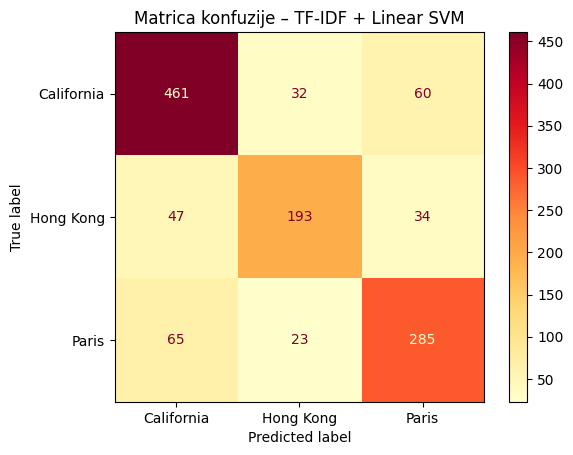

In [ ]:
ConfusionMatrixDisplay.from_estimator(
    pipe_tfidf_svm,
    X_test,
    y_test,
    display_labels=y_levels,
    cmap='YlOrRd'
)

plt.title("Matrica konfuzije – TF-IDF + Linear SVM")
plt.show()

Prema datoj matrici konfuzije, možemo da iznesemo zaključak da je što se tiče

*   klase **California**: prisutno je 461 tačno predviđenih instanci, dok je 32
netačno prepoznato kao Hong Kong i 60 kao Paris
*   klase **Hong Kong**: prisutno je 190 tačno predviđenih instanci, dok je 47 netačno prepoznato kao California i 34 kao Paris
*   klase **Paris**: prisutno je 285 tačno predviđenih instanci dok je 65 netačno prepoznato kao California i 23 kao Hong Kong

Matrica konfuzije pokazuje da Linear SVM u kombinaciji sa TF-IDF reprezentacijom ostvaruje stabilne i uravnotežene performanse za sve tri klase. Najbolji rezultati postižu se za klasu **California**, gde je većina instanci pravilno klasifikovana, uz relativno mali broj grešaka.

Klase **Hong Kong** i **Paris** takođe su dobro razdvojene, pri čemu se primećuje manji stepen međusobnog mešanja u odnosu na TF-IDF + Naive Bayes model. Posebno je uočljivo da je broj pogrešnih klasifikacija između klasa **Hong Kong** i **Paris** smanjen, što ukazuje da Linear SVM bolje hvata granice između klasa u visoko-dimenzionalnom TF-IDF prostoru.

Rezultati ukazuju da se lokacije Disneyland parkova mogu razlikovati ne samo po eksplicitnim informacijama u recenzijama, već i po implicitnim jezičkim obrascima u načinu na koji posetioci izražavaju svoja iskustva. Linear SVM model uspeva da identifikuje te obrasce i iskoristi ih za pouzdaniju klasifikaciju lokacije na osnovu samog teksta recenzije.

# Unapređenje Modela 3: **TD-IDF + LinearSVM + SMOTE**

In [ ]:
tfidf_vectorizer = TfidfVectorizer(
    tokenizer=spacy_preprocessing,
    ngram_range=(1, 2),
    min_df=0.01,
    norm='l2',
    use_idf=True,
    smooth_idf=True
)

column_transformer_tfidf = ColumnTransformer(
    transformers=[
        ('tfidf', tfidf_vectorizer, 'Review_Text')
    ],
    remainder='passthrough'  # Review_Length i Rating
)

smote = SMOTE(random_state=RAND_STATE)

svm_classifier = SVC(
    kernel='linear',
    C=1,
    random_state=RAND_STATE
)

pipe_tfidf_svm_smote = ImbPipeline(
    steps=[
        ('vectorizer', column_transformer_tfidf),
        ('resampling', smote),        # SMOTE samo nad trening skupom
        ('classifier', svm_classifier)
    ],
    verbose=True
)

pipe_tfidf_svm_smote.fit(X_train, y_train)

predictions_tfidf_svm_smote = pipe_tfidf_svm_smote.predict(X_test)

print("\nClassification report (TF-IDF + Linear SVM + SMOTE)\n")
print(metrics.classification_report(
    y_test,
    predictions_tfidf_svm_smote,
    target_names=y_levels
))

bacc_tfidf_svm_smote = metrics.balanced_accuracy_score(
    y_test,
    predictions_tfidf_svm_smote
)
print(f"Balanced accuracy: {bacc_tfidf_svm_smote:.4f}")

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[Pipeline] ........ (step 1 of 3) Processing vectorizer, total= 2.4min
[Pipeline] ........ (step 2 of 3) Processing resampling, total=   0.2s
[Pipeline] ........ (step 3 of 3) Processing classifier, total= 7.3min

Classification report (TF-IDF + Linear SVM + SMOTE)

              precision    recall  f1-score   support

  California       0.82      0.80      0.81       553
   Hong Kong       0.74      0.78      0.76       274
       Paris       0.77      0.77      0.77       373

    accuracy                           0.79      1200
   macro avg       0.78      0.78      0.78      1200
weighted avg       0.79      0.79      0.79      1200

Balanced accuracy: 0.7835


U ovom delu analize primenjena je SMOTE metoda kako bi se rešio problem debalansa klasa u skupu podataka. S obzirom na to da su klase **Hong Kong** i **Paris** imale značajno manji broj uzoraka u poređenju sa klasom **California**, postojala je opasnost da model favorizuje većinsku klasu.

SMOTE funkcioniše generisanjem sintetičkih uzoraka manjinskih klasa korišćenjem algoritma k-najbližih suseda. Rezultati pokazuju da je uvođenje SMOTE tehnike dovelo do porasta balansirane tačnosti sa 76.74% na 78.35%. Posebno značajno poboljšanje ostvareno je kod klase sa najmanje uzoraka (**Hong Kong**), gde je recall porastao sa 0.70 na 0.78, čime je postignuta veća robusnost i objektivnost klasifikatora.

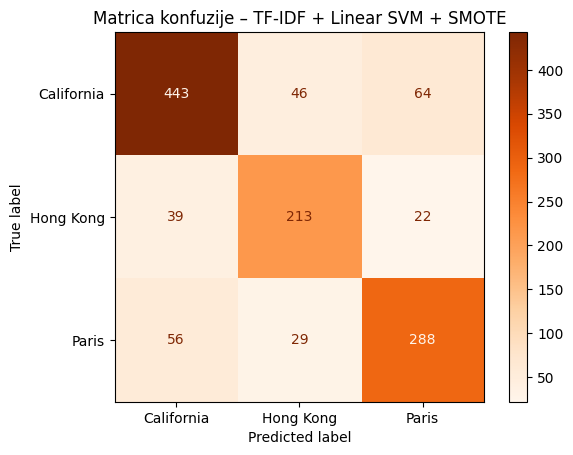

In [ ]:
ConfusionMatrixDisplay.from_estimator(
    pipe_tfidf_svm_smote,
    X_test,
    y_test,
    display_labels=y_levels,
    cmap='Oranges'
)

plt.title("Matrica konfuzije – TF-IDF + Linear SVM + SMOTE")
plt.show()

Prema datoj matrici konfuzije, možemo da iznesemo zaključak da je što se tiče

*   klase **California**: prisutno je 443 tačno predviđenih instanci, dok je 46
netačno prepoznato kao Hong Kong i 64 kao Paris
*   klase **Hong Kong**: prisutno je 213 tačno predviđenih instanci, dok je 39 netačno prepoznato kao California i 22 kao Paris
*   klase **Paris**: prisutno je 288 tačno predviđenih instanci dok je 56 netačno prepoznato kao California i 29 kao Hong Kong

Detaljnom analizom matrice konfuzije potvrđuje se opravdanost upotrebe SMOTE tehnike. Primarna prednost ogleda se u klasi **Hong Kong**, gde je broj tačnih predviđanja porastao sa 190 na 213. Iako je kod većinske klase (**California**) došlo do blagog pada tačnih predviđanja (sa 461 na 443), to je očekivana posledica smanjenja pristrasnosti modela ka većinskoj klasi.

Model sa SMOTE tehnikom pokazuje ravnomerniju raspodelu grešaka, što ga čini pouzdanijim u realnim uslovima gde je važno podjednako precizno prepoznati sve tri geografske lokacije, a ne samo onu koja je najzastupljenija među podacima.

# Model 4: **TF-IDF + Logistic Regression**

### Logistic Regression u klasifikaciji teksta

Logistička regresija je jedan od osnovnih i najčešće korišćenih linearnih modela za klasifikaciju, naročito u zadacima obrade teksta. Iako u svom nazivu sadrži termin regresija, ovaj algoritam se koristi za klasifikacione probleme, gde je cilj predvideti kojoj klasi pripada neka instanca.

Osnovna ideja logističke regresije je da se linearna kombinacija ulaznih atributa transformiše u verovatnoću pripadnosti određenoj klasi pomoću logističke (sigmoidne) funkcije. Na osnovu dobijene verovatnoće, model donosi odluku o klasi kojoj instanca pripada.

U kontekstu klasifikacije teksta, logistička regresija je posebno pogodna jer:
*   dobro funkcioniše u visoko-dimenzionalnim prostorima, kakvi nastaju nakon TF-IDF vektorizacije,
*   omogućava interpretabilnost modela, jer koeficijenti ukazuju na značaj pojedinih atributa
*   često daje rezultate uporedive sa Support Vector Machines (SVM) kada se koristi sa linearnim kernelom.

U ovom radu, logistička regresija je primenjena u kombinaciji sa TF-IDF reprezentacijom teksta, kako bi se dodatno uporedile performanse različitih linearnih klasifikatora nad istim skupom atributa. Dobijeni rezultati omogućavaju poređenje sa prethodno primenjenim Naive Bayes i SVM modelima i doprinose sveobuhvatnijoj evaluaciji pristupa klasifikaciji recenzija po lokaciji.

In [ ]:
tfidf_vectorizer = TfidfVectorizer(
    tokenizer=spacy_preprocessing,
    ngram_range=(1, 2),
    min_df=0.01,
    norm='l2',
    use_idf=True,
    smooth_idf=True
)

column_transformer_tfidf = ColumnTransformer(
    transformers=[
        ('tfidf', tfidf_vectorizer, 'Review_Text')
    ],
    remainder='passthrough'
)

pipe_tfidf_lr = Pipeline([
    ('vectorizer', column_transformer_tfidf),
    ('classifier', LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        random_state=RAND_STATE
    ))
])

pipe_tfidf_lr.fit(X_train, y_train)

predictions_tfidf_lr = pipe_tfidf_lr.predict(X_test)

print("\n Classification report (TF-IDF + Logistic Regression) \n")
print(metrics.classification_report(y_test, predictions_tfidf_lr, target_names=y_levels))

bacc_lr = metrics.balanced_accuracy_score(y_test, predictions_tfidf_lr)
print(f"Balanced accuracy: {bacc_lr:.4f}")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



 Classification report (TF-IDF + Logistic Regression) 

              precision    recall  f1-score   support

  California       0.86      0.80      0.83       553
   Hong Kong       0.73      0.80      0.76       274
       Paris       0.77      0.80      0.78       373

    accuracy                           0.80      1200
   macro avg       0.78      0.80      0.79      1200
weighted avg       0.80      0.80      0.80      1200

Balanced accuracy: 0.7964


TF-IDF + Logistic Regression daje dosta dobre rezultate jer kombinuje linearni model s informativnom reprezentacijom teksta, što je vrlo pogodno za ovaj zadatal klasifikacije. Naš zadatak prepoznavanja lokacije na osnovu recenzije nije ekstremno kompleksan semantički (npr. ne radi o razumevanju ironije). Razlike između recenzija za **California**, **Paris** i **Hong Kong** često se manifestuju kroz frekvenciju i kombinacije termina, a ne kroz duboko kontekstualno značenje. Za razliku od Naive Bayes modela, Logistic Regression ne pretpostavlja nezavisnost termina, što omogućava bolje modelovanje realnih obrazaca u recenzijama, gde se sličan vokabular koristi na različite načine u zavisnosti od lokacije. Rezultat toga je stabilna i uravnotežena klasifikacija.

Klasa **California** je najpreciznije klasifikovana (F1 = 0.83), što ukazuje da recenzije za ovaj park sadrže prepoznatljive i konzistentne termine karakteristične za ovu lokaciju.

Za klase **Hong Kong** i **Paris**, recall od 0.80 pokazuje da model uspešno prepoznaje većinu instanci ovih klasa, iako su one sadržajno sličnije i češće koriste opšti turistički vokabular. Uprkos tome, Logistic Regression uspeva da zadrži dobar balans između preciznosti i odziva, što potvrđuje njenu sposobnost da razlikuje suptilne razlike u jeziku recenzija vezane za različite lokacije.

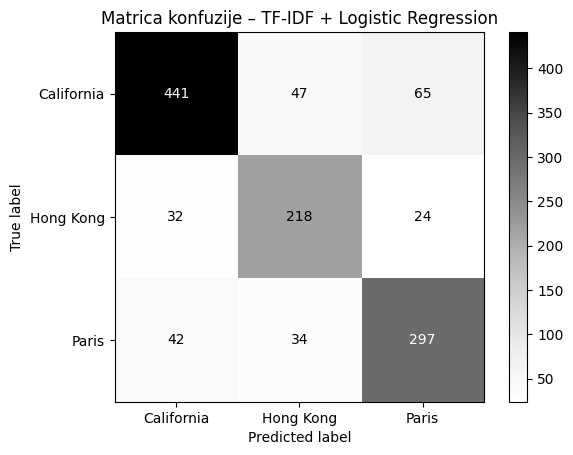

In [ ]:
ConfusionMatrixDisplay.from_estimator(
    pipe_tfidf_lr,
    X_test,
    y_test,
    display_labels=y_levels,
    cmap='Greys'
)

plt.title("Matrica konfuzije – TF-IDF + Logistic Regression")
plt.show()

Prema datoj matrici konfuzije, možemo da iznesemo zaključak da je što se tiče

*   klase **California**: prisutno je 441 tačno predviđenih instanci, dok je 47
netačno prepoznato kao Hong Kong i 65 kao Paris
*   klase **Hong Kong**: prisutno je 218 tačno predviđenih instanci, dok je 32 netačno prepoznato kao California i 24 kao Paris
*   klase **Paris**: prisutno je 297 tačno predviđenih instanci dok je 42 netačno prepoznato kao California i 34 kao Hong Kong

Klasa **California** ima najveći broj tačno klasifikovanih instanci, ali se primećuje određeni broj pogrešnih predikcija ka klasi Paris. Ovo ukazuje da deo recenzija deli sličan vokabular vezan za opšte turističko iskustvo (npr. gužva, redovi, cene), što može otežati jasnu distinkciju između ove dve lokacije.

Kod klase **Hong Kong**, broj pogrešnih klasifikacija je relativno nizak i ravnomerno raspoređen prema preostalim klasama, što sugeriše da model uspešno prepoznaje specifične jezičke obrasce karakteristične za ovu lokaciju.

Klasa **Paris** pokazuje dobru separabilnost, sa većinom instanci pravilno klasifikovanih, dok se greške najčešće javljaju u odnosu na klasu California. Ovo se može objasniti činjenicom da recenzije za evropske i američke parkove često koriste slične izraze za opis iskustva, dok se suptilne razlike bolje hvataju linearnim modelima poput logističke regresije.

# Model 5: **Word Embeddings + Linear SVM**

Učitavanje spaCy modela sa vektorima reči

In [ ]:
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 1.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
spacy_model = spacy.load("en_core_web_lg")

In [ ]:
class ReviewVectorizer(BaseEstimator, TransformerMixin):

    def __init__(self, spacy_pipeline):
        self.spacy_pipeline = spacy_pipeline
        self.D = len(self.spacy_pipeline.vocab['word'].vector)

    def spacy_tokenizer(self, doc):
        tokens = self.spacy_pipeline(doc)
        tokens = [
            token for token in tokens
            if not token.is_punct
            and not token.is_space
            and not token.like_num
            and not token.is_stop
        ]
        return [token.lemma_.lower() for token in tokens]

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transformed = np.zeros((len(X), self.D))
        dropped = 0

        for i, text in enumerate(X):
            words = self.spacy_tokenizer(text)
            vecs = [self.spacy_pipeline.vocab[w].vector
                    for w in words if self.spacy_pipeline.vocab[w].has_vector]

            if len(vecs) > 0:
                X_transformed[i] = np.mean(vecs, axis=0)
            else:
                dropped += 1

        if dropped > 0:
            print(f"Dokumenti bez validnih embedding-a: {dropped}")

        return X_transformed

In [ ]:
vectorizer = ReviewVectorizer(spacy_pipeline=spacy_model)
normaliser = RobustScaler()

column_transformer = ColumnTransformer(
    transformers=[
        ('embeddings', vectorizer, 'Review_Text'),
        ('numeric', normaliser, ['Review_Length', 'Rating'])
    ]
)

svm_emb = SVC(kernel='linear', C=1, random_state=RAND_STATE)

pipe_embeddings = Pipeline(
    steps=[
        ('features', column_transformer),
        ('classifier', svm_emb)
    ]
)

pipe_embeddings.fit(X_train, y_train)

# Evaluacija
predictions_emb_svm = pipe_embeddings.predict(X_test)

print("\nClassification report (Word Embeddings + Linear SVM)\n")
print(metrics.classification_report(y_test, predictions_emb_svm, target_names=y_levels))

print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test, predictions_emb_svm))


Classification report (Word Embeddings + Linear SVM)

              precision    recall  f1-score   support

  California       0.78      0.86      0.82       553
   Hong Kong       0.82      0.69      0.75       274
       Paris       0.77      0.75      0.76       373

    accuracy                           0.79      1200
   macro avg       0.79      0.77      0.77      1200
weighted avg       0.79      0.79      0.78      1200

Balanced accuracy: 0.765261934021172


Klasa **California** postiže najviši recall što znači da model uspešno prepoznaje većinu recenzija koje zaista pripadaju ovoj lokaciji. Još jednom, možemo to objasniti prisustvom specifičnih termina karakterističnim za originalan Disneyland park.

Kod klase **Hong Kong**, primećujemo najveću preciznost ali najniži recall. Dakle model uglavnom tačno predvidi Hong Kong ali deo stvarnih recenzija svrsta pogrešno u druge klase. Ovo je moguća posledica kraćih i manje detaljnih recenzija kao i upotrebe opštijih termina.

Rezultati klase **Paris** su uravnoteženi (slična preciznost i recall) što ukazuje da embeddings uspevaju da uhvate određene semantičke obrasce vezane za ovu lokaciju ali i da je svakako prisutno preklapanje s drugim lokacijama.

Ovi rezultati potvrđuju da naprednije reprezentacije teksta ne moraju nužno nadmašiti jednostavnije metode, posebno u zadacima gde razlike između klasa proizilaze iz konkretnih termina i lokalnih referenci, a ne iz opšte semantike teksta.

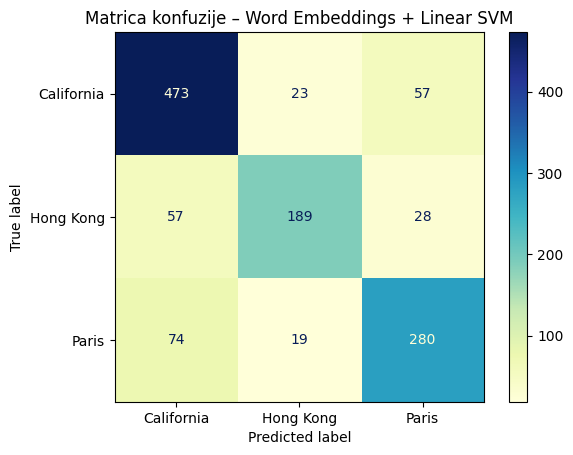

In [ ]:
ConfusionMatrixDisplay.from_estimator(
    pipe_embeddings,
    X_test,
    y_test,
    display_labels=y_levels,
    cmap='YlGnBu'
)

plt.title("Matrica konfuzije – Word Embeddings + Linear SVM")
plt.show()

Prema datoj matrici konfuzije, možemo da iznesemo zaključak da je što se tiče

*   klase **California**: prisutno je 473 tačno predviđenih instanci, dok je 23
netačno prepoznato kao Hong Kong i 57 kao Paris
*   klase **Hong Kong**: prisutno je 189 tačno predviđenih instanci, dok je 57 netačno prepoznato kao California i 28 kao Paris
*   klase **Paris**: prisutno je 280 tačno predviđenih instanci dok je 74 netačno prepoznato kao California i 19 kao Hong Kong

Posebno je uočljivo da se kod klase **Paris** javlja izražena asimetrija u pogrešnim klasifikacijama. Broj recenzija loše prepoznatih kao **Hong Kong** je relativno mali a **California** znatno veći. Ovakav obrazac objašnjava se činjenicom kulturoloških/tematskih/jezičkih sličnosti između komentara posetioca evropskom i američkom parku dok su one manje prisutne među posetiocima azijske atrakcije.

Sličan obrazac možemo da primetimo i kod klase **Hong Kong** gde je veći broj instanci pogrešno klasifikovan kao **California**, što ide u prilog činjenici da klasa **California** prestavlja centralni deo prostora odluka modela najverovatnije zbog dominantnosti i raznovrsnosti recenzija.

# **Poređenje svih modela**

## Analiza metrika

In [ ]:
def get_model_metrics(y_true, y_pred, model_name):

    report = metrics.classification_report(
        y_true,
        y_pred,
        output_dict=True
    )

    b_acc = metrics.balanced_accuracy_score(y_true, y_pred)
    macro_avg = report['macro avg']
    weighted_avg = report['weighted avg']

    results = {
        'Model': model_name,
        'Macro Precision': macro_avg['precision'],
        'Macro Recall': macro_avg['recall'],
        'Macro F1-Score': macro_avg['f1-score'],
        'Weighted Precision': weighted_avg['precision'],
        'Weighted Recall': weighted_avg['recall'],
        'Weighted F1-Score': weighted_avg['f1-score'],
        'Balanced Accuracy': b_acc
    }

    return results

In [ ]:
model_predictions = {
    'BoW + MultinomialNB': predictions_bow,
    'BoW + MultinomialNB (tuned)': predictions_tuned,
    'TF-IDF + MultinomialNB': predictions_tfidf_mnb,
    'TF-IDF + Linear SVM': predictions_tfidf_svm, #prom
    'TF-IDF + Linear SVM + SMOTE': predictions_tfidf_svm_smote,
    'TF-IDF + Logistic Regression': predictions_tfidf_lr, #prom
    'Word Embeddings + Linear SVM': predictions_emb_svm
}

all_results = []

for model_name, model_pred in model_predictions.items():
    model_res = get_model_metrics(y_test, model_pred, model_name)
    all_results.append(model_res)

all_results_df = pd.DataFrame(all_results)
all_results_df.set_index("Model", inplace=True)
all_results_df = all_results_df.apply(lambda x: round(x, 4))

print("\nPoređenje performansi modela\n")
display(all_results_df)


Poređenje performansi modela



,Macro Precision,Macro Recall,Macro F1-Score,Weighted Precision,Weighted Recall,Weighted F1-Score,Balanced Accuracy
Model,,,,,,,
BoW + MultinomialNB,0.7787,0.7886,0.7810,0.7983,0.7917,0.7930,0.7886
BoW + MultinomialNB (tuned),0.8067,0.8160,0.8089,0.8239,0.8183,0.8193,0.8160
TF-IDF + MultinomialNB,0.6760,0.6780,0.6747,0.6923,0.6933,0.6907,0.6780
TF-IDF + Linear SVM,0.7782,0.7674,0.7721,0.7822,0.7825,0.7818,0.7674
TF-IDF + Linear SVM + SMOTE,0.7777,0.7835,0.7804,0.7877,0.7867,0.7870,0.7835
TF-IDF + Logistic Regression,0.7849,0.7964,0.7898,0.8003,0.7967,0.7976,0.7964
Word Embeddings + Linear SVM,0.7895,0.7653,0.7750,0.7862,0.7850,0.7836,0.7653


Na osnovu uporednog prikaza performansi svih razmatranih modela može se uočiti nekoliko važnih zaključaka. Najbolje ukupne rezultate ostvaruje **BoW + Multinomial Naive Bayes (tuned)** model, koji postiže najvišu balansiranu tačnost (0.8160), kao i najviše vrednosti makro i ponderisanih F1-mera. Ovo ukazuje da je pravilno podešavanje hiperparametara, čak i kod jednostavnijih modela poput **BoW + Naive Bayes**, od velikog značaja za postizanje boljih performansi.

Model **TF-IDF + Logistic Regression** takođe pokazuje vrlo stabilne i uravnotežene rezultate, sa balansiranom tačnošću od 0.7964, što ga čini konkurentnim izborom, naročito zbog dobre interpretabilnosti i ravnomernog tretiranja svih klasa. Sa druge strane, **TF-IDF + Multinomial Naive Bayes** ostvaruje najslabije rezultate, što potvrđuje da pretpostavka nezavisnosti osobina, karakteristična za Naive Bayes, nije pogodna za TF-IDF reprezentaciju u ovom kontekstu.

Modeli zasnovani na word embeddings i Linear SVM postižu solidne, ali nešto slabije rezultate u poređenju sa najboljim BoW i TF-IDF modelima. Iako embeddings uspevaju da uhvate semantičke odnose između reči, njihova prednost u ovom zadatku nije u potpunosti iskorišćena, što se može objasniti relativno kratkim i tematski sličnim recenzijama, gde frekvencijski obrasci (BoW) već nose dovoljno informacija za razdvajanje klasa.

U celini, rezultati pokazuju da jednostavniji modeli, uz adekvatno podešavanje, mogu biti jednako ili čak uspešniji od kompleksnijih pristupa, kao i da je izbor reprezentacije teksta snažno zavisan od same prirode podataka i cilja klasifikacije.

## Analiza najčešće korišćenih termina

Kako bi se dodatno objasnili rezultati klasifikacije i uočene greške u modelima,
analizirani su najčešće korišćeni termini u recenzijama za svaku klasu.

In [ ]:
def top_terms_per_class(
    data,
    text_col='Review_Text',
    class_col='Class',
    tokenizer=spacy_preprocessing,
    top_n=15
):
    results = {}

    for cls in data[class_col].unique():
        texts = data[data[class_col] == cls][text_col]

        vectorizer = CountVectorizer(
            tokenizer=tokenizer,
            min_df=0.01,
            ngram_range=(1, 2)
        )

        X = vectorizer.fit_transform(texts)
        word_freq = X.sum(axis=0)

        freq_df = pd.DataFrame({
            'term': vectorizer.get_feature_names_out(),
            'frequency': word_freq.A1
        })

        results[cls] = freq_df.sort_values(
            by='frequency',
            ascending=False
        ).head(top_n)

    return results

In [ ]:
top_terms = top_terms_per_class(data_reduced)

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
for cls, df in top_terms.items():
    print(f"\nNajčešći termini za klasu: {cls}")
    display(df)


Najčešći termini za klasu: California


,term,frequency
499,not,3616
644,ride,3223
550,park,3087
782,time,2631
173,disneyland,2446
139,day,2405
165,disney,1788
399,line,1390
567,pass,1256
832,visit,1171



Najčešći termini za klasu: Hong Kong


,term,frequency
492,not,1656
624,ride,1242
547,park,1190
152,disney,1110
165,disneyland,1101
128,day,1005
761,time,753
807,visit,632
370,kid,555
680,small,551



Najčešći termini za klasu: Paris


,term,frequency
677,not,3626
759,park,3139
907,ride,2609
245,disney,2162
1113,time,1982
203,day,1821
866,queue,1488
421,good,1129
262,disneyland,1100
1167,visit,1067


Analiza najčešćih termina po klasama pokazuje da se recenzije za sve tri lokacije u velikoj meri oslanjaju na sličan vokabular koji opisuje opšte iskustvo boravka u Disneyland parkovima. Termini poput *park, ride, wait, time, day i good* dominiraju u svim klasama, što ukazuje da korisnici nezavisno od lokacije naglašavaju univerzalne aspekte posete. Ovakvo preklapanje vokabulara otežava razdvajanje klasa, posebno za modele koji ne uzimaju u obzir kontekst ili semantiku. Ovi podaci pružaju objašnjenje za uočene greške u matricama konfuzije i potvrđuju da ograničenja performansi modela proističu iz prirode podataka, a ne iz nedostatka modela.

## Zaključak

Kroz ovaj projekat, uspešno je demonstrirana primena tehnika obrade prirodnog jezika i mašinskog učenja na klasifikaciju racenzija posetilaca Disneyland parkova. Kroz proces od pretprocesiranja pa do evaluacije modela, došli smo do sledećih ključnih saznanja:

*   ***Superiornost SVM-a***: U poređenju sa ostalim modelima, Linear SVM u kombinaciji sa TF-IDF i Word Embeddings tehnikama, pokazao je najveću preciznost. Ovo potvrđuje da su granice između klasa u tekstualnom prostoru dovoljno kompleksne da zahtevaju algoritme koji efikasno barataju visokodimenzionalnim podacima.
*   ***Značaj pretprocesiranja***: Čišćenje teksta pomoću spaCy biblioteke bilo je presudno za smanjenje šuma i direktno je uticalo na dobijanje stabilnih rezultata.
*   ***Balansirana tačnost kao glavna metrika***: S obzirom na neujednačen broj recenzija po klasama, kroz ceo rad vodili smo se korišćenjem balansirane tačnosti. Upravo ona nam je omogućila objektivan uvid u to koliko svaki model prepoznaje specifičnosti svake od tri lokacije a ne samo najbrojnije.





Na kraju, ovaj rad dokazuje da algoritmi mogu veoma uspešno da pročitaju razliku u iskustvima raznoraznih posetilaca, jer se ispostavilo da sam način na koji ljudi pišu recenzije jasno otkriva gde se u svetu nalaze čak i bez direktnog pominjanja lokacije.